<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/bawang_merah_us.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [5]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [6]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [7]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7fd35f0fea00>)

In [8]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [9]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [10]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.bawang_merah_ukuran_sedang.values
date = dataset.index

## Train test val split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


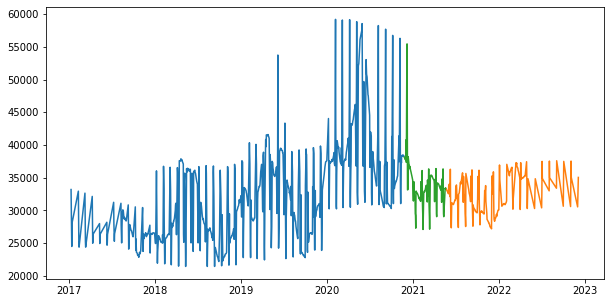

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [13]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [14]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_bamer_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 19s 48ms/step - loss: 0.1872 - mae: 0.3897 - mape: 80.2325 - val_loss: 0.0178 - val_mae: 0.1232 - val_mape: 53.7824
Epoch 2/30
44/44 [==============================] - 1s 22ms/step - loss: 0.1271 - mae: 0.3045 - mape: 59.5884 - val_loss: 0.0057 - val_mae: 0.0680 - val_mape: 37.0514
Epoch 3/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0878 - mae: 0.2327 - mape: 42.3532 - val_loss: 0.0040 - val_mae: 0.0421 - val_mape: 33.8353
Epoch 4/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0645 - mae: 0.1905 - mape: 34.2718 - val_loss: 0.0078 - val_mae: 0.0687 - val_mape: 51.7709
Epoch 5/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0508 - mae: 0.1638 - mape: 30.3773 - val_loss: 0.0136 - val_mae: 0.1006 - val_mape: 69.7139
Epoch 6/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0428 - mae: 0.1478 - mape: 28.5613 - val_loss: 0.0194 - val_mae: 0.1252 - val_mape: 83.16

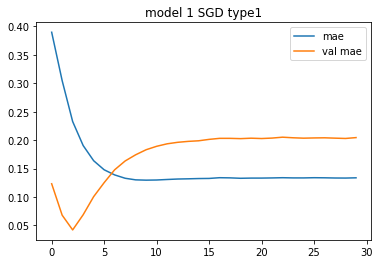

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 9ms/step
5585.55 18.093868 6182.644418046375


,date,actual,prediction
0,2021-05-20,33350,39042.523438
1,2021-05-21,33350,39050.398438
2,2021-05-24,33100,39059.437500
3,2021-05-25,33000,39035.214844
4,2021-05-27,32900,39032.195312
...,...,...,...
229,2022-11-02,34300,38328.417969
230,2022-11-03,37550,38430.593750
231,2022-11-04,35050,38314.496094
232,2022-12-01,30550,38425.597656


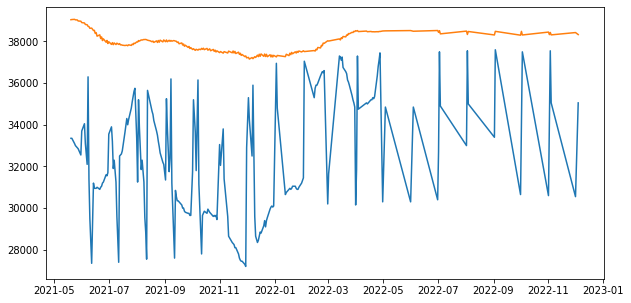

In [ ]:
prediction = forecast_predict(model, test_bamer_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_bamer = pd.DataFrame()
data_new_bamer['date'] = y_test
data_new_bamer['actual'] = x_test
data_new_bamer['prediction'] = data_result
data_new_bamer.to_csv('bamer_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_bamer.date, data_new_bamer.actual)
plt.plot(data_new_bamer.date, data_new_bamer.prediction)
data_new_bamer

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0297 - mae: 0.1370 - mape: 1269326.1250 - val_loss: 0.0246 - val_mae: 0.1444 - val_mape: 93.4832
Epoch 2/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0268 - mae: 0.1303 - mape: 1071976.0000 - val_loss: 0.0230 - val_mae: 0.1386 - val_mape: 90.3824
Epoch 3/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0258 - mae: 0.1277 - mape: 1263738.6250 - val_loss: 0.0239 - val_mae: 0.1421 - val_mape: 92.2248
Epoch 4/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0258 - mae: 0.1275 - mape: 1192284.6250 - val_loss: 0.0235 - val_mae: 0.1405 - val_mape: 91.3745
Epoch 5/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0253 - mae: 0.1258 - mape: 1156434.0000 - val_loss: 0.0211 - val_mae: 0.1315 - val_mape: 86.5882
Epoch 6/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0244 - mae: 0.1248 - mape: 1164283.5000 - val_loss: 0.0182 

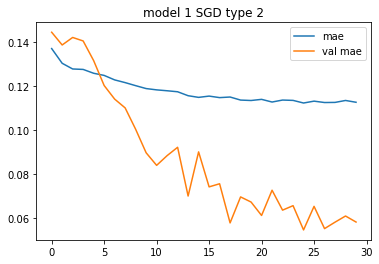

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
2511.1433 8.004003 2999.3897712701496


,date,actual,prediction
0,2021-05-20,33350,39042.523438
1,2021-05-21,33350,39050.398438
2,2021-05-24,33100,39059.437500
3,2021-05-25,33000,39035.214844
4,2021-05-27,32900,39032.195312
...,...,...,...
229,2022-11-02,34300,38328.417969
230,2022-11-03,37550,38430.593750
231,2022-11-04,35050,38314.496094
232,2022-12-01,30550,38425.597656


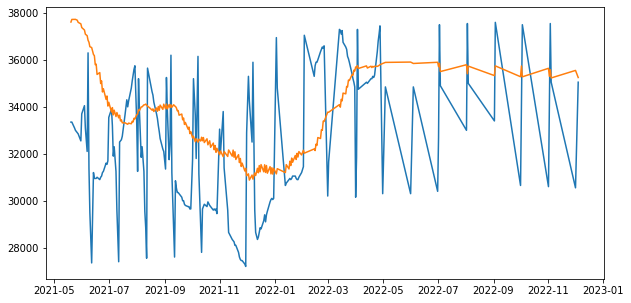

In [ ]:
win_size1 = 60
test_bamer_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_bamer_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_bamer_1 = pd.DataFrame()
data_new_bamer_1['actual'] = x_test
data_new_bamer_1['prediction'] = data_result_1
data_new_bamer_1.to_csv('bamer_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_bamer_1.actual)
plt.plot(y_test, data_new_bamer_1.prediction)
data_new_bamer

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 2s 17ms/step - loss: 0.0257 - mae: 0.1234 - mape: 59.2907 - val_loss: 0.0060 - val_mae: 0.0556 - val_mape: 44.0702
Epoch 2/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0257 - mae: 0.1233 - mape: 58.9405 - val_loss: 0.0057 - val_mae: 0.0541 - val_mape: 43.0542
Epoch 3/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0257 - mae: 0.1232 - mape: 58.6019 - val_loss: 0.0057 - val_mae: 0.0537 - val_mape: 42.8232
Epoch 4/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0257 - mae: 0.1235 - mape: 59.0410 - val_loss: 0.0056 - val_mae: 0.0530 - val_mape: 42.3718
Epoch 5/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0257 - mae: 0.1231 - mape: 57.9985 - val_loss: 0.0058 - val_mae: 0.0546 - val_mape: 43.4166
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0257 - mae: 0.1232 - mape: 58.3755 - val_loss: 0.0059 - val_mae: 0.0552 - val_mape: 43.783

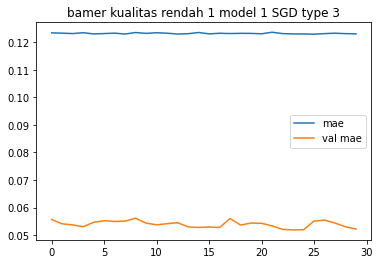

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('bamer kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
2398.711 7.6048536 2905.4454047529443


,actual,prediction
0,33350,37516.656250
1,33350,37620.925781
2,33100,37621.078125
3,33000,37615.191406
4,32900,37577.289062
...,...,...
229,34300,35069.476562
230,37550,35361.195312
231,35050,35003.855469
232,30550,35335.339844


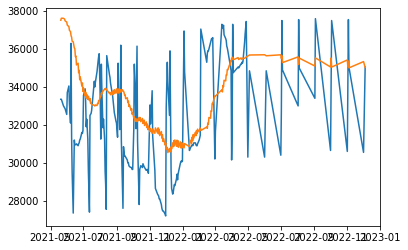

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_bamer_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_bamer_2 = pd.DataFrame()
# data_new_bamer1['date'] = date_test
data_new_bamer_2['actual'] = x_test
data_new_bamer_2['prediction'] = data_result_2
data_new_bamer_2.to_csv('bamer_model1_sgd_type3')

plt.plot(y_test, data_new_bamer_2.actual)
plt.plot(y_test, data_new_bamer_2.prediction)
data_new_bamer_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 5s 43ms/step - loss: 0.2174 - mae: 0.4249 - mape: 88.4420 - val_loss: 0.0259 - val_mae: 0.1490 - val_mape: 63.6744
Epoch 2/30
44/44 [==============================] - 1s 21ms/step - loss: 0.1316 - mae: 0.3092 - mape: 60.7141 - val_loss: 0.0058 - val_mae: 0.0685 - val_mape: 37.2513
Epoch 3/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0499 - mae: 0.1688 - mape: 32.6881 - val_loss: 0.0122 - val_mae: 0.0936 - val_mape: 65.9602
Epoch 4/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0320 - mae: 0.1347 - mape: 32.4385 - val_loss: 0.0129 - val_mae: 0.0970 - val_mape: 67.8614
Epoch 5/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0316 - mae: 0.1327 - mape: 31.6468 - val_loss: 0.0132 - val_mae: 0.0983 - val_mape: 68.5823
Epoch 6/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0314 - mae: 0.1308 - mape: 30.2675 - val_loss: 0.0141 - val_mae: 0.1023 - val_mape: 70.826

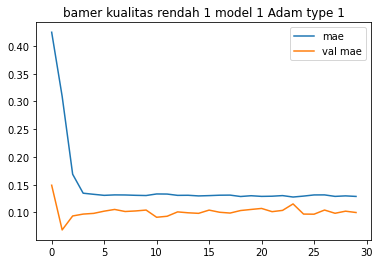

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('bamer kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
3032.304 9.844718 3557.5120519823963


,actual,prediction
0,33350,37941.957031
1,33350,38069.605469
2,33100,37973.347656
3,33000,38019.714844
4,32900,37880.621094
...,...,...
229,34300,36037.558594
230,37550,36095.093750
231,35050,35980.851562
232,30550,36097.148438


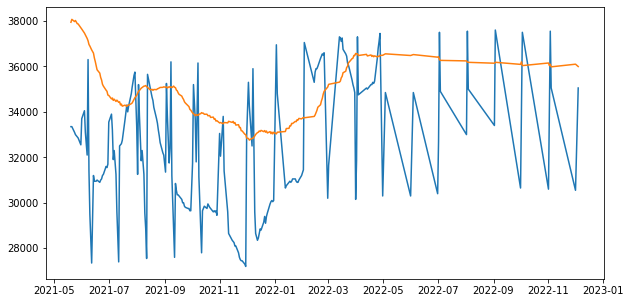

In [ ]:
prediction_a = forecast_predict(model_a, test_bamer_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_bamer_a = pd.DataFrame()
# data_new_bamer1['date'] = date_test
data_new_bamer_a['actual'] = x_test
data_new_bamer_a['prediction'] = data_result_a
data_new_bamer_a.to_csv('bamer_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_bamer_a.actual)
plt.plot(y_test, data_new_bamer_a.prediction)
data_new_bamer_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0216 - mae: 0.1145 - mape: 938593.6875 - val_loss: 0.0112 - val_mae: 0.0885 - val_mape: 63.1343
Epoch 2/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0210 - mae: 0.1119 - mape: 1102799.2500 - val_loss: 0.0066 - val_mae: 0.0596 - val_mape: 46.7244
Epoch 3/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0204 - mae: 0.1091 - mape: 950379.3125 - val_loss: 0.0081 - val_mae: 0.0701 - val_mape: 52.7611
Epoch 4/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0203 - mae: 0.1092 - mape: 1004987.4375 - val_loss: 0.0076 - val_mae: 0.0668 - val_mape: 50.9462
Epoch 5/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0200 - mae: 0.1089 - mape: 967339.9375 - val_loss: 0.0053 - val_mae: 0.0501 - val_mape: 40.7778
Epoch 6/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0200 - mae: 0.1081 - mape: 951747.5000 - val_loss: 0.0086 - va

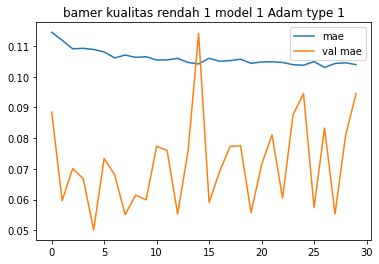

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('bamer kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
3172.8933 10.140187 3747.925025931015


,actual,prediction
0,33350,40084.609375
1,33350,40469.410156
2,33100,40186.843750
3,33000,40525.378906
4,32900,40129.968750
...,...,...
229,34300,35836.625000
230,37550,36008.214844
231,35050,35768.226562
232,30550,36073.351562


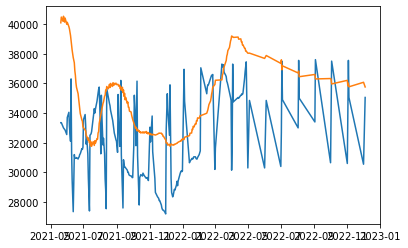

In [ ]:
prediction_a1 = forecast_predict(model_a, test_bamer_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_bamer_a1 = pd.DataFrame()
data_new_bamer_a1['actual'] = x_test
data_new_bamer_a1['prediction'] = data_result_a1
data_new_bamer_a1.to_csv('bamer_model1_adam_type2.csv')

plt.plot(y_test, data_new_bamer_a1.actual)
plt.plot(y_test, data_new_bamer_a1.prediction)
data_new_bamer_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 2s 18ms/step - loss: 0.0238 - mae: 0.1171 - mape: 54.9406 - val_loss: 0.0076 - val_mae: 0.0676 - val_mape: 50.8030
Epoch 2/30
84/84 [==============================] - 2s 16ms/step - loss: 0.0238 - mae: 0.1150 - mape: 52.8110 - val_loss: 0.0077 - val_mae: 0.0681 - val_mape: 51.0640
Epoch 3/30
84/84 [==============================] - 2s 17ms/step - loss: 0.0237 - mae: 0.1141 - mape: 51.8260 - val_loss: 0.0069 - val_mae: 0.0636 - val_mape: 48.3078
Epoch 4/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0237 - mae: 0.1143 - mape: 51.8150 - val_loss: 0.0078 - val_mae: 0.0691 - val_mape: 51.6438
Epoch 5/30
84/84 [==============================] - 2s 16ms/step - loss: 0.0235 - mae: 0.1143 - mape: 52.2470 - val_loss: 0.0080 - val_mae: 0.0700 - val_mape: 52.1947
Epoch 6/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0235 - mae: 0.1140 - mape: 51.9548 - val_loss: 0.0083 - val_mae: 0.0721 - val_mape: 53.416

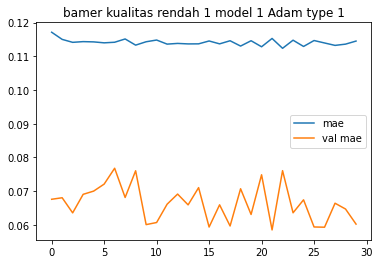

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('bamer kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
2475.2688 7.739365 3048.184377625474


,actual,prediction
0,33350,38677.308594
1,33350,39072.882812
2,33100,38900.113281
3,33000,39244.093750
4,32900,39029.882812
...,...,...
229,34300,33976.468750
230,37550,34167.535156
231,35050,33878.058594
232,30550,34186.410156


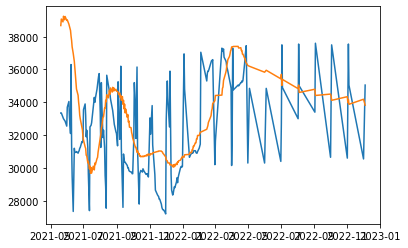

In [ ]:
prediction_a2 = forecast_predict(model_a, test_bamer_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_bamer_a2 = pd.DataFrame()
# data_new_bamer1['date'] = date_test
data_new_bamer_a2['actual'] = x_test
data_new_bamer_a2['prediction'] = data_result_a2
data_new_bamer_a2.to_csv('bamer_model1_adam_type3.csv')

plt.plot(y_test, data_new_bamer_a2.actual)
plt.plot(y_test, data_new_bamer_a2.prediction)
data_new_bamer_a2

## model 1

### Adam

In [ ]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-trai

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 20s 112ms/step - loss: 0.1895 - mae: 0.3854 - mape: 79.2657 - val_loss: 0.0037 - val_mae: 0.0436 - val_mape: 32.0593
Epoch 2/15
44/44 [==============================] - 1s 27ms/step - loss: 0.0481 - mae: 0.1647 - mape: 34.5287 - val_loss: 0.0099 - val_mae: 0.0823 - val_mape: 59.2837
Epoch 3/15
44/44 [==============================] - 1s 24ms/step - loss: 0.0363 - mae: 0.1474 - mape: 35.3395 - val_loss: 0.0097 - val_mae: 0.0810 - val_mape: 58.5573
Epoch 4/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0367 - mae: 0.1431 - mape: 33.0476 - val_loss: 0.0193 - val_mae: 0.1251 - val_mape: 83.0143
Epoch 5/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0341 - mae: 0.1419 - mape: 34.8387 - val_loss: 0.0136 - val_mae: 0.1006 - val_mape: 69.6347
Epoch 6/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0352 - mae: 0.1417 - mape: 33.7388 - val_loss: 0.0162 - val_mae: 0.1120 - val_mape: 76.0

17/17 [==============================] - 0s 7ms/step - loss: 0.0951 - mae: 0.2615 - mape: 37.1503


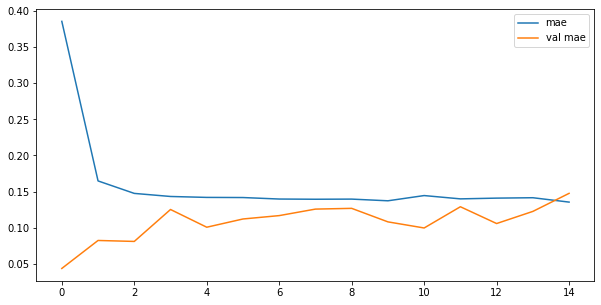

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_bamer_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_bamer1 = pd.DataFrame()
data_new_bamer1['actual'] = x_test
data_new_bamer1['prediction'] = data_result1
data_new_bamer1.to_csv('bamer_model2_adam_type1.csv')

data_new_bamer1

131/131 [==============================] - 2s 9ms/step
3871.0427 12.655205 4530.222511091481


,actual,prediction
0,33350,37884.312500
1,33350,37722.597656
2,33100,37936.421875
3,33000,37765.757812
4,32900,37955.851562
...,...,...
229,34300,36694.425781
230,37550,36683.093750
231,35050,36695.648438
232,30550,36677.496094


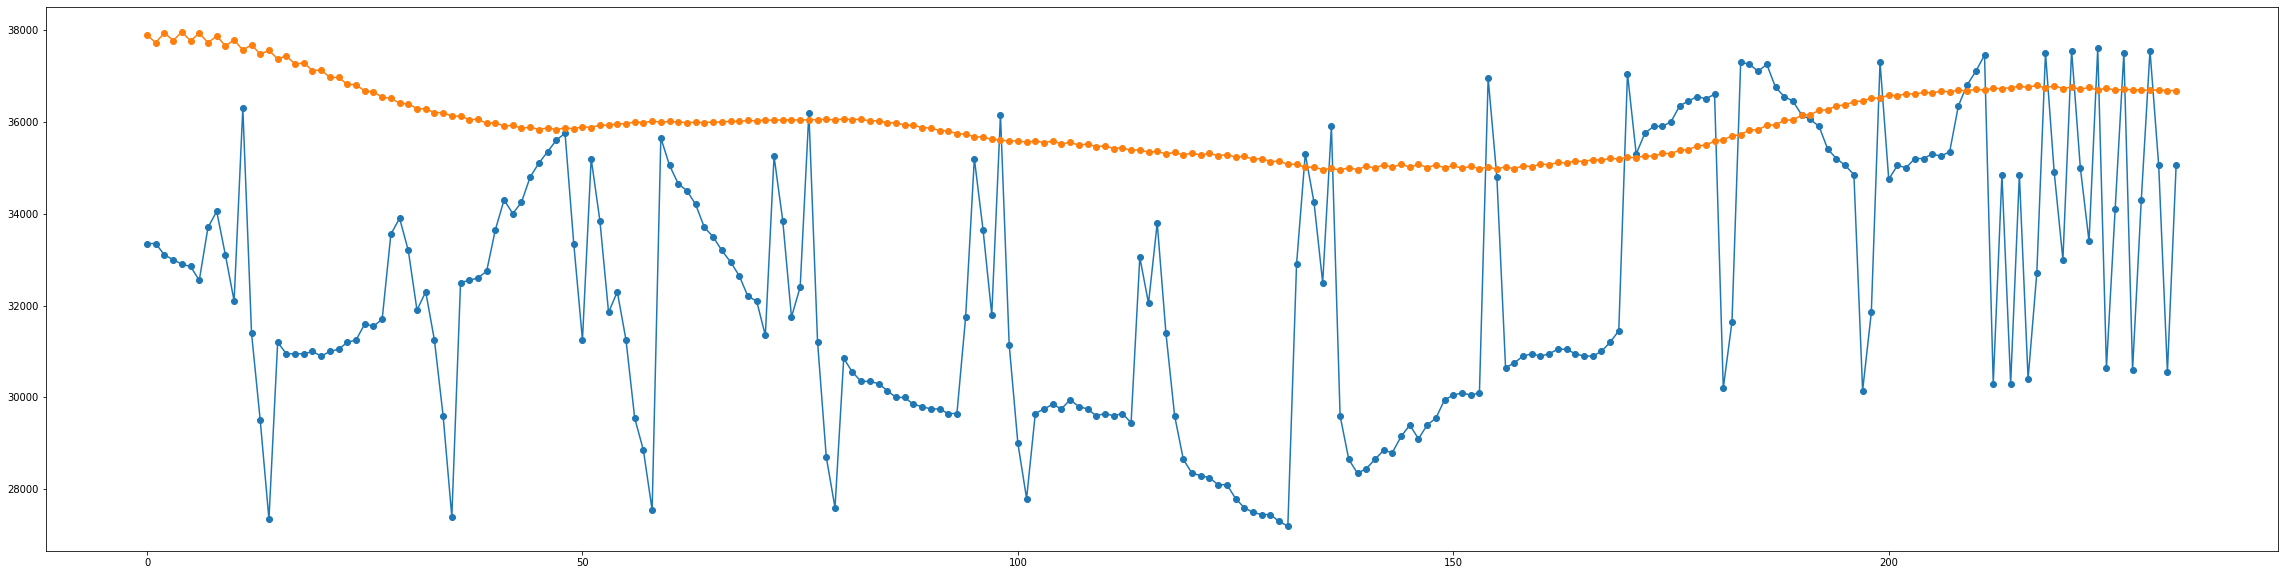

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_bamer1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_bamer1['prediction'], '-o')

#### Type 2

In [ ]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 29s 11ms/step - loss: 0.0248 - mae: 0.1233 - mape: 767860.5625 - val_loss: 0.0064 - val_mae: 0.0592 - val_mape: 46.1370
Epoch 2/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0208 - mae: 0.1103 - mape: 1049796.3750 - val_loss: 0.0169 - val_mae: 0.1139 - val_mape: 77.2923
Epoch 3/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0204 - mae: 0.1075 - mape: 988951.8125 - val_loss: 0.0099 - val_mae: 0.0814 - val_mape: 58.9711
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0207 - mae: 0.1094 - mape: 956328.9375 - val_loss: 0.0079 - val_mae: 0.0694 - val_mape: 52.0277
Epoch 5/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0200 - mae: 0.1077 - mape: 923903.5625 - val_loss: 0.0046 - val_mae: 0.0459 - val_mape: 37.2376
Epoch 6/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0198 - mae: 0.1060 - mape: 951021.8750 - val_loss: 0.0115 -

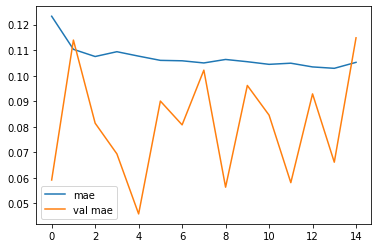

In [ ]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 4ms/step
3289.046 10.410536 3928.5879142511244


,actual,prediction
0,33350,42109.960938
1,33350,41511.222656
2,33100,42335.242188
3,33000,41713.910156
4,32900,42322.054688
...,...,...
229,34300,35998.335938
230,37550,35519.218750
231,35050,36011.652344
232,30550,35536.062500


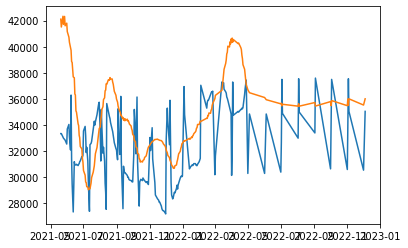

In [ ]:
prediction1_1 = forecast_predict(model1, test_bamer_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1_1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_bamer1_1 = pd.DataFrame()
data_new_bamer1_1['actual'] = x_test
data_new_bamer1_1['prediction'] = data_result1_1
data_new_bamer1_1.to_csv('bamer_model2_adam_type2.csv')

plt.plot(y_test, data_new_bamer1_1.actual)
plt.plot(y_test, data_new_bamer1_1.prediction)
data_new_bamer1_1

#### Type 3

In [ ]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0230 - mae: 0.1123 - mape: 52.2506 - val_loss: 0.0091 - val_mae: 0.0775 - val_mape: 55.3112
Epoch 2/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0225 - mae: 0.1127 - mape: 52.3118 - val_loss: 0.0072 - val_mae: 0.0661 - val_mape: 48.6019
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0225 - mae: 0.1121 - mape: 50.2269 - val_loss: 0.0064 - val_mae: 0.0615 - val_mape: 45.5996
Epoch 4/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0222 - mae: 0.1119 - mape: 51.5534 - val_loss: 0.0076 - val_mae: 0.0690 - val_mape: 50.1917
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0219 - mae: 0.1103 - mape: 49.6886 - val_loss: 0.0069 - val_mae: 0.0654 - val_mape: 47.7667
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0220 - mae: 0.1096 - mape: 48.7810 - val_loss: 0.0077 - val_mae: 0.0701 - val_mape: 50.711

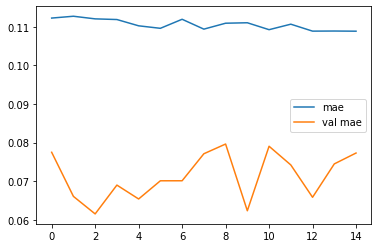

In [ ]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
2934.923 9.249197 3578.6796447852103


,actual,prediction
0,33350,39920.039062
1,33350,39494.308594
2,33100,40415.121094
3,33000,40116.113281
4,32900,40845.523438
...,...,...
229,34300,36157.347656
230,37550,35547.937500
231,35050,35960.320312
232,30550,35311.910156


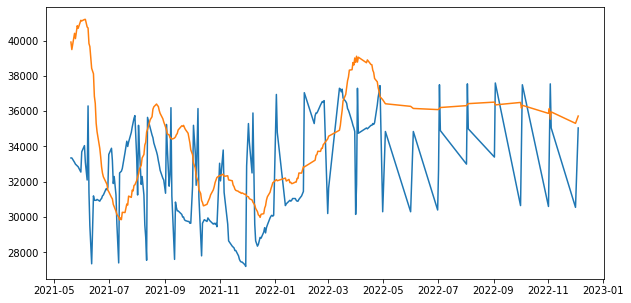

In [ ]:
prediction1_2 = forecast_predict(model1, test_bamer_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_bamer1_2 = pd.DataFrame()
data_new_bamer1_2['actual'] = x_test
data_new_bamer1_2['prediction'] = data_result1_2
data_new_bamer1_2.to_csv('bamer_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_bamer1_2.actual)
plt.plot(y_test, data_new_bamer1_2.prediction)

data_new_bamer1_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 44ms/step - loss: 0.2267 - mae: 0.4371 - mape: 91.7330 - val_loss: 0.0253 - val_mae: 0.1469 - val_mape: 62.7023
Epoch 2/15
44/44 [==============================] - 1s 23ms/step - loss: 0.1628 - mae: 0.3575 - mape: 72.3864 - val_loss: 0.0104 - val_mae: 0.0944 - val_mape: 44.5594
Epoch 3/15
44/44 [==============================] - 1s 23ms/step - loss: 0.1212 - mae: 0.2928 - mape: 56.4667 - val_loss: 0.0045 - val_mae: 0.0576 - val_mape: 34.7704
Epoch 4/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0923 - mae: 0.2405 - mape: 43.9902 - val_loss: 0.0040 - val_mae: 0.0423 - val_mape: 34.1597
Epoch 5/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0728 - mae: 0.2048 - mape: 36.6122 - val_loss: 0.0068 - val_mae: 0.0609 - val_mape: 47.3904
Epoch 6/15
44/44 [==============================] - 1s 24ms/step - loss: 0.0595 - mae: 0.1803 - mape: 32.5731 - val_loss: 0.0113 - val_mae: 0.0895 - val_mape: 63.517

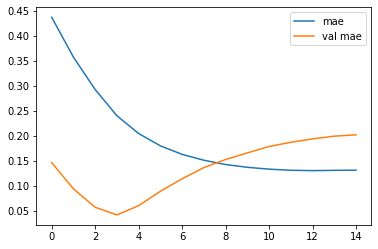

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
6905.2217 22.230145 7422.462664102798


,actual,prediction
0,33350,39765.496094
1,33350,39763.128906
2,33100,39772.832031
3,33000,39762.500000
4,32900,39761.675781
...,...,...
229,34300,39501.128906
230,37550,39457.132812
231,35050,39493.808594
232,30550,39457.445312


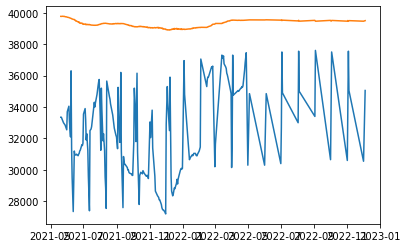

In [ ]:
prediction1_a = forecast_predict(model1_a, test_bamer_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_bamer1_a = pd.DataFrame()
data_new_bamer1_a['actual'] = x_test
data_new_bamer1_a['prediction'] = data_result1_a
data_new_bamer1_a.to_csv('bamer_model2_sgd_type1.csv')


plt.plot(y_test, data_new_bamer1_a.actual)
plt.plot(y_test, data_new_bamer1_a.prediction)

data_new_bamer1_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0320 - mae: 0.1407 - mape: 1352538.2500 - val_loss: 0.0268 - val_mae: 0.1518 - val_mape: 97.4522
Epoch 2/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0286 - mae: 0.1337 - mape: 1095604.2500 - val_loss: 0.0266 - val_mae: 0.1512 - val_mape: 97.1248
Epoch 3/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0277 - mae: 0.1322 - mape: 1140649.2500 - val_loss: 0.0239 - val_mae: 0.1421 - val_mape: 92.2758
Epoch 4/15
718/718 [==============================] - 9s 12ms/step - loss: 0.0266 - mae: 0.1292 - mape: 1239541.1250 - val_loss: 0.0253 - val_mae: 0.1468 - val_mape: 94.8054
Epoch 5/15
718/718 [==============================] - 9s 13ms/step - loss: 0.0259 - mae: 0.1280 - mape: 1235511.1250 - val_loss: 0.0236 - val_mae: 0.1409 - val_mape: 91.6431
Epoch 6/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0255 - mae: 0.1278 - mape: 1153027.2500 - val_loss: 0.01

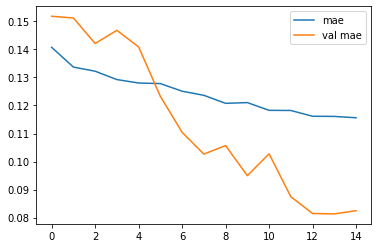

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
4629.844 15.035042 5275.130140574733


,actual,prediction
0,33350,39429.093750
1,33350,39422.476562
2,33100,39491.750000
3,33000,39461.109375
4,32900,39472.070312
...,...,...
229,34300,38192.332031
230,37550,38020.167969
231,35050,38144.429688
232,30550,38007.210938


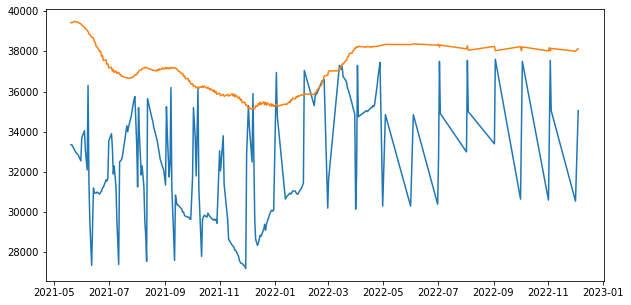

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_bamer_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_bamer1_a1 = pd.DataFrame()
data_new_bamer1_a1['actual'] = x_test
data_new_bamer1_a1['prediction'] = data_result1_a1
data_new_bamer1_a1.to_csv('bamer_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_bamer1_a1.actual)
plt.plot(y_test, data_new_bamer1_a1.prediction)
data_new_bamer1_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 20ms/step - loss: 0.0265 - mae: 0.1250 - mape: 63.3347 - val_loss: 0.0079 - val_mae: 0.0686 - val_mape: 51.9740
Epoch 2/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0263 - mae: 0.1243 - mape: 61.0171 - val_loss: 0.0076 - val_mae: 0.0663 - val_mape: 50.6941
Epoch 3/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0264 - mae: 0.1244 - mape: 61.6653 - val_loss: 0.0071 - val_mae: 0.0632 - val_mape: 48.8526
Epoch 4/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0263 - mae: 0.1237 - mape: 59.2888 - val_loss: 0.0073 - val_mae: 0.0644 - val_mape: 49.5394
Epoch 5/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0263 - mae: 0.1240 - mape: 60.5485 - val_loss: 0.0073 - val_mae: 0.0645 - val_mape: 49.6172
Epoch 6/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0263 - mae: 0.1241 - mape: 60.4118 - val_loss: 0.0072 - val_mae: 0.0640 - val_mape: 49.287

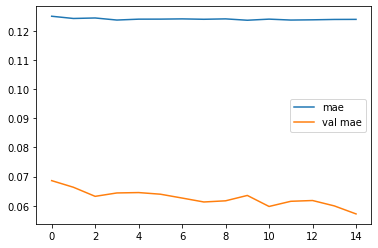

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
4043.67 13.155246 4678.228510878877


,actual,prediction
0,33350,38997.980469
1,33350,38991.460938
2,33100,39057.902344
3,33000,39027.410156
4,32900,39031.398438
...,...,...
229,34300,37582.851562
230,37550,37402.660156
231,35050,37531.941406
232,30550,37393.261719


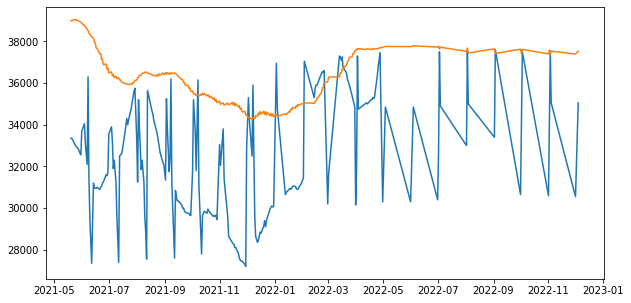

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_bamer_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_bamer1_a2 = pd.DataFrame()
data_new_bamer1_a2['actual'] = x_test
data_new_bamer1_a2['prediction'] = data_result1_a2
data_new_bamer1_a2.to_csv('bamer_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_bamer1_a2.actual)
plt.plot(y_test, data_new_bamer1_a2.prediction)

data_new_bamer1_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 35ms/step - loss: 0.2255 - mae: 0.4358 - mape: 91.4064 - val_loss: 0.0265 - val_mae: 0.1511 - val_mape: 64.8068
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 0.1687 - mae: 0.3643 - mape: 73.8571 - val_loss: 0.0112 - val_mae: 0.0982 - val_mape: 45.7361
Epoch 3/50
44/44 [==============================] - 1s 16ms/step - loss: 0.1271 - mae: 0.3030 - mape: 58.9970 - val_loss: 0.0049 - val_mae: 0.0615 - val_mape: 35.5317
Epoch 4/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0981 - mae: 0.2506 - mape: 46.2645 - val_loss: 0.0038 - val_mae: 0.0422 - val_mape: 33.2391
Epoch 5/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0771 - mae: 0.2121 - mape: 37.9196 - val_loss: 0.0061 - val_mae: 0.0559 - val_mape: 44.3711
Epoch 6/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0632 - mae: 0.1866 - mape: 33.6486 - val_loss: 0.0105 - val_mae: 0.0855 - val_mape: 61.156

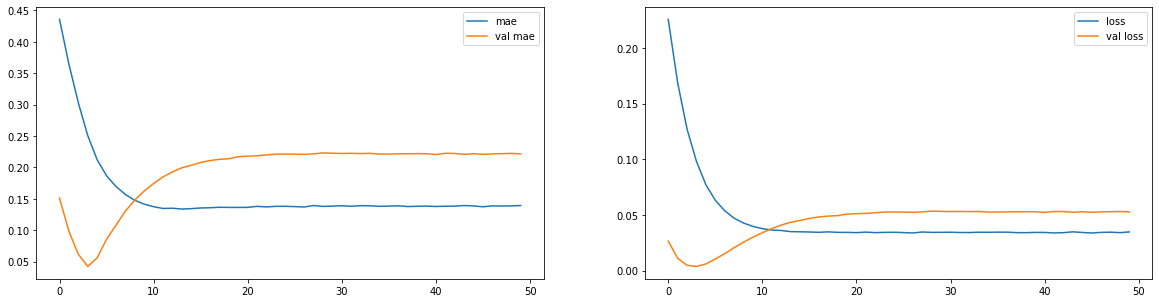

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 2s 6ms/step
7569.9707 24.314991 8064.14608002608


,actual,prediction
0,33350,40386.648438
1,33350,40382.050781
2,33100,40360.500000
3,33000,40340.222656
4,32900,40391.054688
...,...,...
229,34300,40072.679688
230,37550,40067.308594
231,35050,40083.636719
232,30550,40074.824219


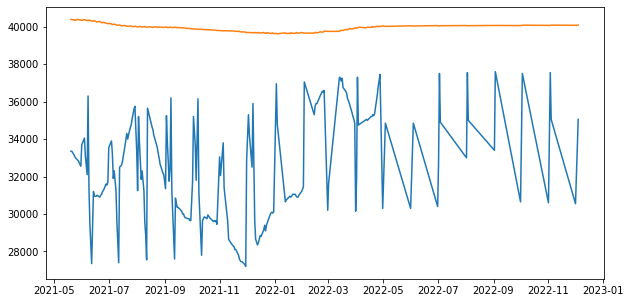

In [ ]:
prediction2 = forecast_predict(model2, test_bamer_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_bamer2 = pd.DataFrame()
data_new_bamer2['actual'] = x_test
data_new_bamer2['prediction'] = data_result2
data_new_bamer2.to_csv('bamer_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_bamer2.actual)
plt.plot(y_test, data_new_bamer2.prediction)
data_new_bamer2

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0348 - mae: 0.1484 - mape: 1373215.3750 - val_loss: 0.0257 - val_mae: 0.1482 - val_mape: 95.4069
Epoch 2/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0310 - mae: 0.1398 - mape: 1241771.7500 - val_loss: 0.0224 - val_mae: 0.1368 - val_mape: 89.3269
Epoch 3/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0298 - mae: 0.1371 - mape: 1152775.0000 - val_loss: 0.0226 - val_mae: 0.1373 - val_mape: 89.6089
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0293 - mae: 0.1369 - mape: 1153418.2500 - val_loss: 0.0210 - val_mae: 0.1314 - val_mape: 86.4008
Epoch 5/50
718/718 [==============================] - 6s 9ms/step - loss: 0.0288 - mae: 0.1351 - mape: 1244132.6250 - val_loss: 0.0197 - val_mae: 0.1265 - val_mape: 83.8209
Epoch 6/50
718/718 [==============================] - 6s 9ms/step - loss: 0.0283 - mae: 0.1347 - mape: 1204555.3750 - val_loss: 0.0211 

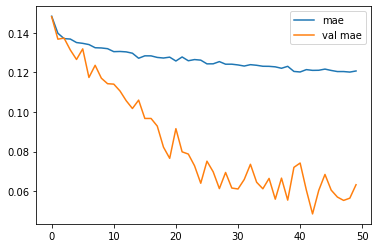

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_bamer_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_bamer2_1 = pd.DataFrame()
data_new_bamer2_1['actual'] = x_test
data_new_bamer2_1['prediction'] = data_result2_1
data_new_bamer2_1.to_csv('bamer_model3_sgd_type2.csv')

data_new_bamer2

199/199 [==============================] - 1s 4ms/step
4197.1606 13.6687355 4865.488259157553


,actual,prediction
0,33350,40386.648438
1,33350,40382.050781
2,33100,40360.500000
3,33000,40340.222656
4,32900,40391.054688
...,...,...
229,34300,40072.679688
230,37550,40067.308594
231,35050,40083.636719
232,30550,40074.824219


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0288 - mae: 0.1320 - mape: 65.3756 - val_loss: 0.0065 - val_mae: 0.0591 - val_mape: 46.2406
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0283 - mae: 0.1303 - mape: 64.7652 - val_loss: 0.0062 - val_mae: 0.0570 - val_mape: 44.9638
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0288 - mae: 0.1313 - mape: 64.1735 - val_loss: 0.0065 - val_mae: 0.0592 - val_mape: 46.2867
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0284 - mae: 0.1307 - mape: 64.8848 - val_loss: 0.0064 - val_mae: 0.0584 - val_mape: 45.8357
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0279 - mae: 0.1300 - mape: 64.4143 - val_loss: 0.0065 - val_mae: 0.0589 - val_mape: 46.0867
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0288 - mae: 0.1309 - mape: 64.3503 - val_loss: 0.0063 - val_mae: 0.0577 - val_mape: 45.377

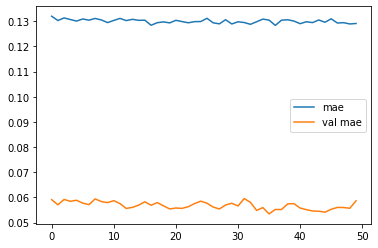

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_bamer_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_bamer2_2 = pd.DataFrame()
data_new_bamer2_2['actual'] = x_test
data_new_bamer2_2['prediction'] = data_result2_2
data_new_bamer2_2.to_csv('bamer_model3_sgd-type3.csv')

data_new_bamer2_2

181/181 [==============================] - 1s 4ms/step
3959.7544 12.894133 4602.337884162787


,actual,prediction
0,33350,38871.675781
1,33350,38688.703125
2,33100,39086.160156
3,33000,39003.070312
4,32900,38785.640625
...,...,...
229,34300,37437.187500
230,37550,37283.351562
231,35050,37327.675781
232,30550,37237.261719


### Adam

In [15]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 dropout (Dropout)           (None, None, 24)          0         
                                                                 
 lstm_1 (LSTM)               (None, 80)                33600     
                                                                 
 dense (Dense)               (None, 24)                1944      
                                                        

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 5s 36ms/step - loss: 0.1787 - mae: 0.3734 - mape: 75.6922 - val_loss: 0.0114 - val_mae: 0.0991 - val_mape: 45.9443
Epoch 2/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0573 - mae: 0.1908 - mape: 41.9462 - val_loss: 0.0044 - val_mae: 0.0430 - val_mape: 35.8484
Epoch 3/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0432 - mae: 0.1618 - mape: 38.1088 - val_loss: 0.0041 - val_mae: 0.0419 - val_mape: 34.3746
Epoch 4/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0398 - mae: 0.1555 - mape: 37.2075 - val_loss: 0.0056 - val_mae: 0.0517 - val_mape: 41.8195
Epoch 5/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0383 - mae: 0.1505 - mape: 35.9267 - val_loss: 0.0062 - val_mae: 0.0567 - val_mape: 44.7684
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0380 - mae: 0.1526 - mape: 36.6282 - val_loss: 0.0069 - val_mae: 0.0626 - val_mape: 48.183

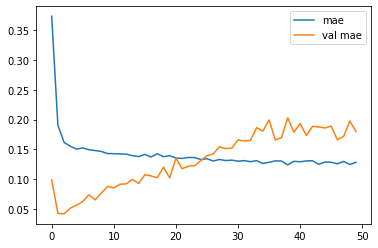

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_bamer_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_bamer2_a = pd.DataFrame()
data_new_bamer2_a['actual'] = x_test
data_new_bamer2_a['prediction'] = data_result2_a
data_new_bamer2_a.to_csv('bamer_model3_adam-type1.csv')

data_new_bamer2_a

131/131 [==============================] - 1s 6ms/step
5923.7026 19.111155 6459.34733545116


,actual,prediction
0,33350,39487.605469
1,33350,39283.648438
2,33100,39073.046875
3,33000,39167.304688
4,32900,39545.914062
...,...,...
229,34300,39684.660156
230,37550,39595.472656
231,35050,39715.496094
232,30550,39611.679688


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0230 - mae: 0.1183 - mape: 951417.0625 - val_loss: 0.0149 - val_mae: 0.1055 - val_mape: 72.6379
Epoch 2/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0225 - mae: 0.1162 - mape: 1021060.4375 - val_loss: 0.0159 - val_mae: 0.1094 - val_mape: 74.9123
Epoch 3/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0214 - mae: 0.1130 - mape: 1172115.7500 - val_loss: 0.0147 - val_mae: 0.1041 - val_mape: 71.9665
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0213 - mae: 0.1102 - mape: 901778.8750 - val_loss: 0.0102 - val_mae: 0.0823 - val_mape: 59.6368
Epoch 5/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0211 - mae: 0.1110 - mape: 1131993.2500 - val_loss: 0.0132 - val_mae: 0.0974 - val_mape: 68.2312
Epoch 6/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0211 - mae: 0.1100 - mape: 961276.8125 - val_loss: 0.0161 - v

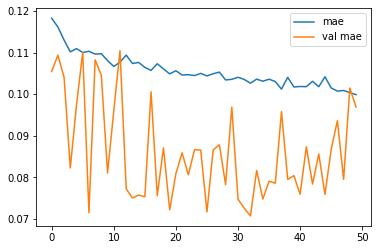

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
4423.868 14.303547 5071.57707227249


,actual,prediction
0,33350,40332.195312
1,33350,40719.398438
2,33100,40149.402344
3,33000,40366.894531
4,32900,40377.019531
...,...,...
229,34300,37930.863281
230,37550,37466.027344
231,35050,37831.968750
232,30550,37693.308594


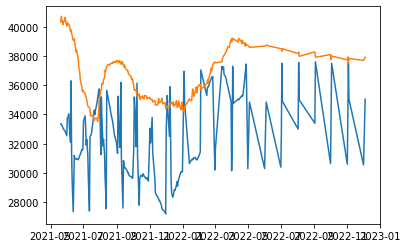

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_bamer_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_bamer2_a1 = pd.DataFrame()
data_new_bamer2_a1['actual'] = x_test
data_new_bamer2_a1['prediction'] = data_result2_a1
data_new_bamer2_a1.to_csv('bamer_model3_adam-type2.csv')

plt.plot(y_test, data_new_bamer2_a1.actual)
plt.plot(y_test, data_new_bamer2_a1.prediction)
data_new_bamer2_a1

#### Type 3

In [16]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 21s 35ms/step - loss: 0.1111 - mae: 0.2752 - mape: 73.4577 - val_loss: 0.0037 - val_mae: 0.0447 - val_mape: 32.3718
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0361 - mae: 0.1500 - mape: 72.6057 - val_loss: 0.0042 - val_mae: 0.0414 - val_mape: 34.4846
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0347 - mae: 0.1472 - mape: 72.9517 - val_loss: 0.0039 - val_mae: 0.0413 - val_mape: 33.1640
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0326 - mae: 0.1416 - mape: 71.3845 - val_loss: 0.0041 - val_mae: 0.0415 - val_mape: 34.2819
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0315 - mae: 0.1392 - mape: 70.8241 - val_loss: 0.0040 - val_mae: 0.0418 - val_mape: 33.9055
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0321 - mae: 0.1399 - mape: 68.2206 - val_loss: 0.0039 - val_mae: 0.0420 - val_mape: 33.50

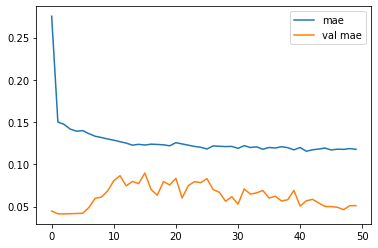

In [17]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 6ms/step
2306.3496 7.2416477 2817.5970258360226


,actual,prediction
0,33350,38104.730469
1,33350,37807.000000
2,33100,38684.835938
3,33000,38349.000000
4,32900,38014.207031
...,...,...
229,34300,35207.800781
230,37550,35021.101562
231,35050,34804.152344
232,30550,34851.457031


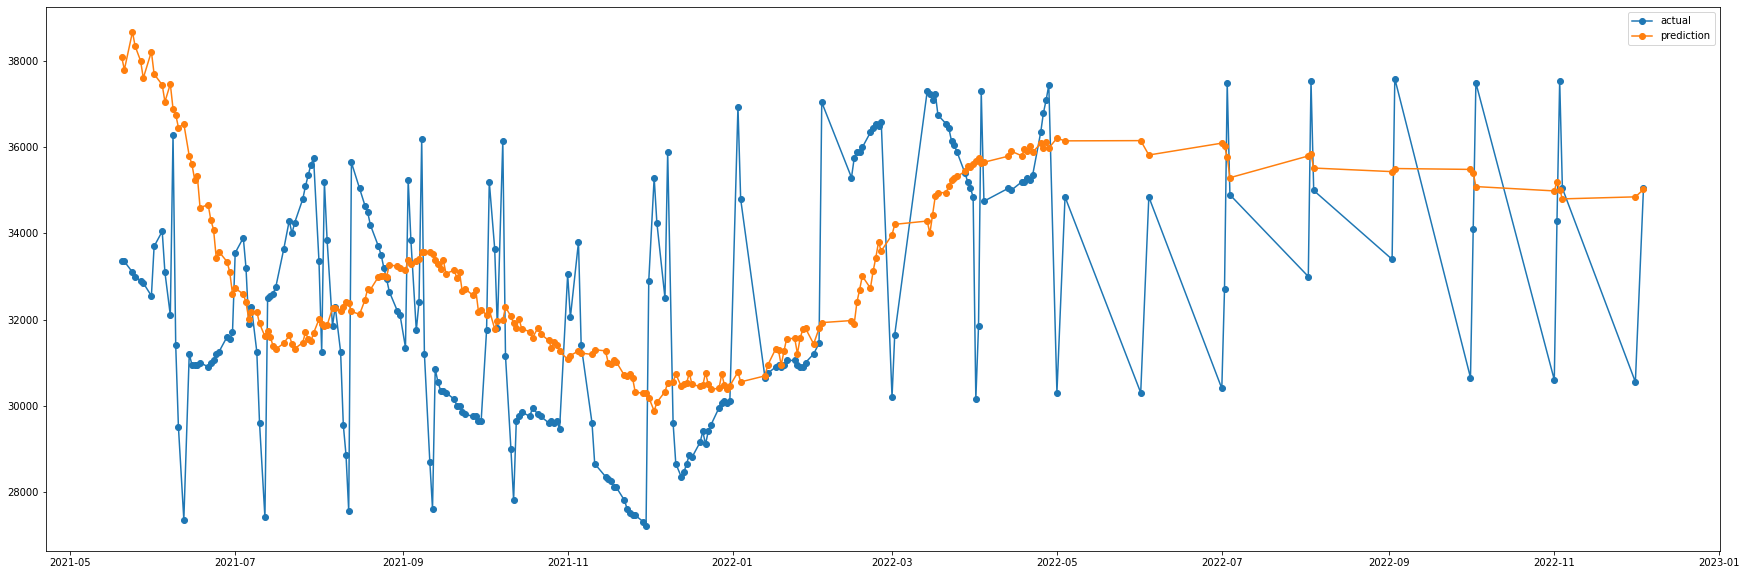

In [20]:
prediction2_a2 = forecast_predict(model2_a, test_bamer_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_bamer2_a2 = pd.DataFrame()
data_new_bamer2_a2['actual'] = x_test
data_new_bamer2_a2['prediction'] = data_result2_a2
data_new_bamer2_a2.to_csv('bamer_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_bamer2_a2.actual, '-o', label='actual')
plt.plot(y_test,data_new_bamer2_a2.prediction, '-o', label='prediction')
plt.legend()
data_new_bamer2_a2